In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import zipfile
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check if GPU is available and set the device accordingly
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'  # Use the first GPU if available
    print("Using GPU for training.")
else:
    device = '/CPU:0'  # Use CPU if no GPU is available
    print("Using CPU for training.")

Using GPU for training.


In [4]:
# Specify the path to your zipped dataset
dataset_zip_path = "C:/Users/sonic/Desktop/NTU Notes PC/Y4/Y4S1/IE4483 - Art Intell & Data Mining/Mini Project/Datasets/datasets.zip"  # Replace with your actual path

In [5]:
# Extract the dataset
temp_dir = "extracted_data"  
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

In [6]:
# Define training, validation, and test directories
train_dir = 'extracted_data/datasets/train'
val_dir = 'extracted_data/datasets/val'
test_dir = 'extracted_data/datasets/test'

In [7]:
# Create datasets
train_datagen = image_dataset_from_directory(
    train_dir, image_size=(150, 150), subset='training', seed=1, validation_split=0.1, batch_size=32
)

val_datagen = image_dataset_from_directory(
    val_dir, image_size=(150, 150), subset='validation', seed=1, validation_split=0.1, batch_size=32
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.
Found 5000 files belonging to 2 classes.
Using 500 files for validation.


In [8]:
# Normalize the datasets
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_datagen.map(normalize_image)
val_dataset = val_datagen.map(normalize_image)

In [9]:
# Model Definition with Dropout to avoid overfitting
cnn = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [10]:
# Compile and Train the Model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use with statement to ensure proper device placement during training
with tf.device(device):
    history = cnn.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
563/563 [==============================] - 24s 23ms/step - loss: 0.6419 - accuracy: 0.6226 - val_loss: 0.5278 - val_accuracy: 0.7520
Epoch 2/10
563/563 [==============================] - 12s 21ms/step - loss: 0.5017 - accuracy: 0.7568 - val_loss: 0.4848 - val_accuracy: 0.7700
Epoch 3/10
563/563 [==============================] - 12s 21ms/step - loss: 0.4209 - accuracy: 0.8085 - val_loss: 0.4286 - val_accuracy: 0.8300
Epoch 4/10
563/563 [==============================] - 12s 21ms/step - loss: 0.3478 - accuracy: 0.8452 - val_loss: 0.4433 - val_accuracy: 0.8260
Epoch 5/10
563/563 [==============================] - 12s 21ms/step - loss: 0.2781 - accuracy: 0.8822 - val_loss: 0.4201 - val_accuracy: 0.8260
Epoch 6/10
563/563 [==============================] - 12s 21ms/step - loss: 0.2140 - accuracy: 0.9122 - val_loss: 0.4889 - val_accuracy: 0.8300
Epoch 7/10
563/563 [==============================] - 12s 21ms/step - loss: 0.1627 - accuracy: 0.9333 - val_loss: 0.5309 - val_accuracy:

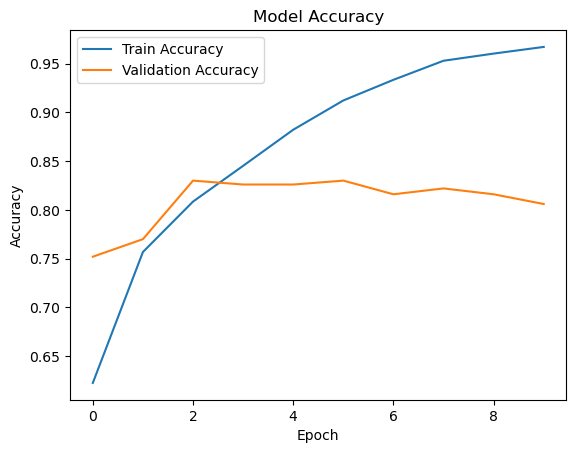

In [11]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [12]:
# Test Data Prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='extracted_data/datasets',
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False,
    classes=['test']
)

Found 500 images belonging to 1 classes.


In [13]:
# Collect predictions
predictions = []
test_ids = [os.path.basename(filepath) for filepath in test_generator.filepaths]

In [14]:
# Run predictions on the test dataset
for batch in test_generator:
    batch_predictions = cnn.predict(batch)
    predictions.extend(batch_predictions)
    if len(predictions) >= test_generator.samples:
        break

In [15]:
# Map predictions to "Cat" or "Dog"
predicted_labels_list = ['Dog' if pred >= 0.5 else 'Cat' for pred in predictions]

In [16]:
# Save predictions to Excel
test_df = pd.DataFrame({'Image ID': test_ids, 'Predicted': predicted_labels_list})

In [17]:
# Save results to Excel file
output_file = 'predictions_output.xlsx'  # Change filename to avoid overwriting
with pd.ExcelWriter(output_file) as writer:
    test_df.to_excel(writer, sheet_name='Test', index=False)

print(f"Test results saved to {output_file}")

Test results saved to predictions_output.xlsx


In [18]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

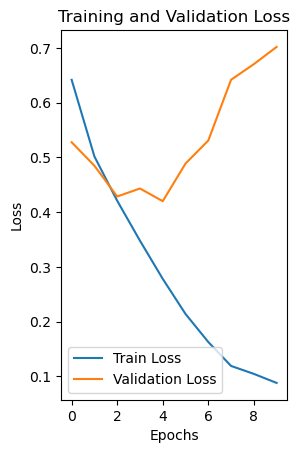

In [19]:
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

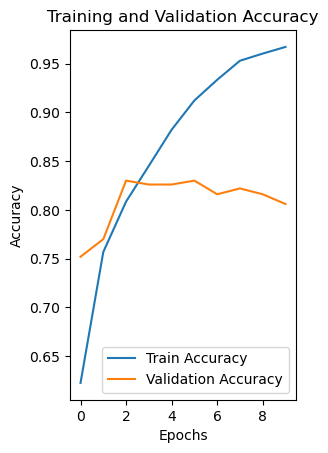

In [20]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()